## Modified Classical Nucleation Theory Parameterized for Clouds

### A long, rambling notebook by a rogue grad student 

Traditional formulations of CNT consider the energetic cost of creating a solid-phase embryo or radius r (also referred to as an i-mer, or cluster, I'll use the terms interchangeably) from the liquid phase. We can also think of clusters in terms of the number of molecules (or irreducible groups of them, ie hexagonal ice needs 6 molecules at once to grow along the a axis, and 3-4 to grow along the c axis), or just the volume they occupy. Maybe one is better than the others?

So the story always begins with a water droplet above freezing temperature. Molecules within the droplet are at some reference chemical potential (let's set it to zero). For now we are only concerned with what happens in the bulk of the droplet (i.e. not near the surface separating the droplet from the surrounding air, we will address this later). Let the temperature drop below zero degrees C, where we might naively expect the droplet to just freeze. They don't, and the exact reasons why are rather puzzling, but here is the basis of a good guess:

Those of us who have read some thermodynamics know that particles (they can be molecules in a liquid/gas or just some sort of discretized elements of a general system) cluster around energy states as close to energy $k_bT$ as possible, where $k_b$ is Boltzmann's constant and $T$ is the temperature of the system. When you heat the system, its constituent elements begin to move to higher energy states (molecules move faster, or maybe transition from liquid to gas). When you cool the system, low energy states are favored. A *Boltzmann distribution* shows just how likely each state is to be occupied by any number of system elements, and expresses this as a probability density function. If we know enough about all the possible states a system may occupy, we can accurately predict the proportion of each state as a function of temperature.

$$
P(s) = \frac{1}{Z}e^{\frac{\epsilon_s}{k_bT}}
$$

Just as we expect, when water cools below 0$^o$C, the ice becomes the preferred state, and molecules indeed start to cluster together, attempting to form ice crystals. *Buuuuuuuut,* there is a problem. As a cluster of ice particles begins to form, they quickly discover that the transition is not beneficial for all involved. Fully formed, hexagonal (or maybe cubic...?) ice crystals are the preferred state, but near the edges of the cluster there exists the *ice-water interface,* (which we describe using the character $\sigma_{iw}$) a sort of halfway state between solid and liquid that actually requires *more* energy than just remaining as a liquid. Depending on the shape and size of the cluster, the relative numbers of molecules that form ice in the bulk (lowering their energy to a favorable state compared with liquid water) versus those that are at the interface (raising their energy to a less favorable state) changes. We often assume (because we are physicists) that these clusters are more or less spherical (there are actually not-so-bad reasons for this, discussed later in the *Laplace Pressure* section), and consider the surface area (interfacial tension) to volume (bulk ice) ratio as an ice embryo grows.

A common way to write the Gibbs free energy for embryo formation in terms of it's radius is:

$$
\Delta G = -\frac{4}{3} \pi r^3\Delta\mu_{bulk}  + 4\pi r^2 \sigma_{iw}\tag{1}
$$

with the bulk chemical potential maybe given by:

$$
\Delta\mu_{bulk} = \frac{k_bTln(S)}{v_{molecular}}
$$

In the first term, $k_bTln(S)$ is the energetic benifit of changing one molecule from water to ice (goes as log of the supersaturation $S$, which is a decreasing function of increasing temperature, ie colder water strongly prefers to be in the ice phase) $v_{molecular}$ is the volume of an ice molecule. The second term is the energetic cost of constructing an ice-water interface, which is less favorable than just remaining a liquid molecule. $\sigma_{iw}$ has units of energy/area and decreases with decreasing temperature. For small embryos, the second term dominates and so ice formation is extremely difficult/unlikely. Since the surface area to volume ratio of most 3d shapes scales (spherical embryos for example, unless they are fractal spheres, then we're fucked) as $1/r$, the volume term will dominate for larger embryos and they become more and more favorable once they reach a certain size (called the *critical radius* or *germ radius*).

Here are some parameterizations of each energy term as functions of temperature. They are empirical (I think?) and the actual values are subject to some debate, but apparently these are good enough for the folks at ETH so here they are:

$
\sigma_{i,w} = 189.081 + 13.1625T + 0.3469T^2+ (3.12\cdot10^{−3})T^3
$

$
ln(e_{s,i}) = 9.550426−(5723.265T^{−1}) + 3.53068  ln(T)−0.00728332T
$

$
ln(e_{s,w}) = 54.842763−6763.22T^{−1} − 4.21ln(T) + 0.000367T + tanh(0.0415(T−218.8))(53.878−1331.22T^{−1} − 9.44523  ln(T) + 0.014025T)
$

where $S$ is defined as $e_{s,w}/e_{s,i}$

lets plot them in Python!

In [1]:
import numpy as np
from matplotlib import pyplot as plt

## Define some constants
NA = 6.02 * 10 ** 23  # Avagadros number
kb = 1.3806503 * 10 ** -23  # m2 kg s-2 K-1 boltzmann const
rho_w = 1000  # kg/m3 bulk density of water
rho_i = 916  # kg/m3 bulk density of ice
Mw = 18.02 / 1000  # kg/mol molar mass of H20
v_mole_w = Mw / (rho_w * NA)  # volume of a single water molecule
v_mole_i = Mw / (rho_i * NA)  # volume of a single ice molecule

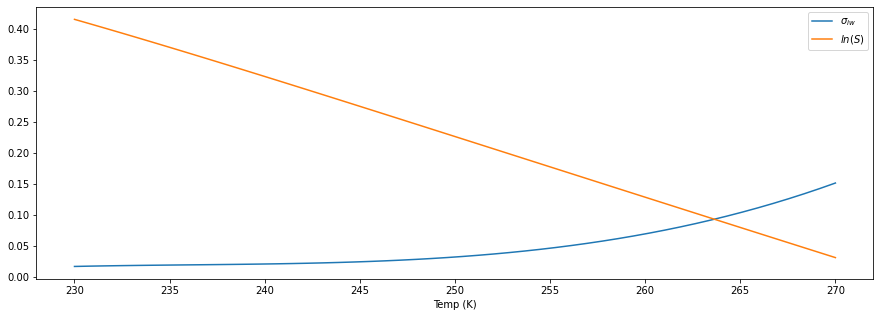

In [2]:
def sig_iw(T):
    """
    calculate surface tension of an ice-water interface given temperature (kelvin)
    """
    T_c = T - 273.15
    sig = (
        189.081 + 13.1625 * T_c + 0.3469 * T_c ** 2 + 3.12 * 10 ** -3 * T_c ** 3
    )  # 10^-3 N/m
    sig *= 10 ** -3  # conversion to SI units J/m2
    return sig


def S_iw(T):
    """
    calculates the saturation ratio of an ice-water interface given temperature (kelvin)
    """
    e_si = np.exp(
        9.550426 - 5723.265 * T ** -1 + 3.53068 * np.log(T) - 0.00728332 * T
    )  # Pa
    e_sw = np.exp(
        54.842763
        - 6763.22 * T ** -1
        - 4.21 * np.log(T)
        + 0.000367 * T
        + np.tanh(0.0415 * (T - 218.8))
        * (53.878 - 1331.22 * T ** -1 - 9.44523 * np.log(T) + 0.014025 * T)
    )  # Pa
    return e_sw / e_si

temps = np.linspace(230,270,50)
fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(temps,sig_iw(temps),label='$\sigma_{iw}$')
ax.plot(temps,np.log(S_iw(temps)),label='$ln(S)$')
ax.legend()
ax.set_xlabel('Temp (K)');

As it gets colder, water molecules increasingly prefer to exist as bulk ice, and become somewhat less averse to being relagated to the ice-water interface. This would lead us to believe that ice is generally easier to form at lower temperatures (and it is!).

Now let's make the diagram that everyone sees in ice-nucleation school: compare the relative contributions of each term as functions of embryo radius

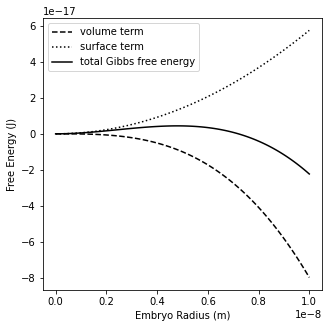

In [3]:
# fix temperature at some value
T = 255  # K

# implement equation 1
r = np.linspace(0, 1e-8, 100) # m

volume_term = -(4 / 3) * np.pi * r ** 3 * kb * T * np.log(S_iw(T)) / v_mole_i
surface_term = 4 * np.pi * r ** 2 * sig_iw(T)
deltaG = volume_term + surface_term

# plot it
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(r,volume_term,label='volume term',color='black',linestyle='--')
ax.plot(r,surface_term,label='surface term',color='black',linestyle=':')
ax.plot(r,deltaG,label='total Gibbs free energy',color='black')
ax.legend()
ax.set_xlabel('Embryo Radius (m)')
ax.set_ylabel('Free Energy (J)');

Neat. This diagram is widely used and not terribly helpful. It is super hard to measure any of these parameters in isolation experimentally. 

It might be a better idea to think of cluster size in terms of embryo volume or number of constituent molecules. This is easy enough to do, just make the appropriate substitutions for $r$

Volume: 

$$
r = \left(\frac{3V_e}{4\pi}\right)^\frac{1}{3}
$$

$$
\Delta G_V = - \frac{V_e}{v_{molecular}}k_bTln(S) + (4\pi)^{\frac{1}{3}}(3V_e)^\frac{2}{3} \sigma_{iw}\tag{2}
$$

Number of molecules:

$$
N = \frac{V_e}{v_{molecular}}
$$

$$
\Delta G_N = - Nk_bTln(S) + (4\pi)^{\frac{1}{3}}(3Nv_{molecular})^\frac{2}{3} \sigma_{iw}\tag{3}
$$

Lets plot them again at a few different temperatures and gain some insight. Also, look how the first term is super easily recognizable as an energy term. Second term is kinda a dog's breakfast but so it goes. 

In [4]:
# handy sphere functions, put these in a library so they dont clutter up the notebook

def radtovol(rad):
    vol = (4 / 3) * np.pi * rad ** 3
    return vol


def voltorad(vol):
    rad = (3 * vol / (4 * np.pi)) ** (1 / 3)
    return rad


def radtosurf(rad):
    surf = 4 * np.pi * rad ** 2
    return surf


def surftorad(surf):
    rad = (surf / 4 / np.pi) ** (1 / 2)
    return rad


def surftovol(surf):
    return radtovol(surftorad(surf))


def voltosurf(vol):
    return radtosurf(voltorad(vol))

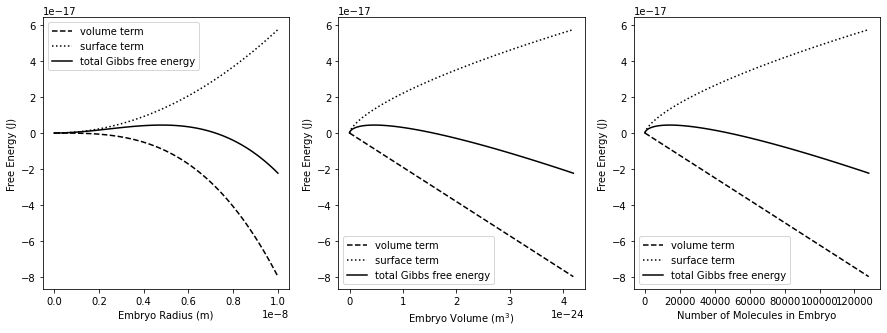

In [5]:
# plot it
fig, ax = plt.subplots(1,3,figsize=(15,5))

# radius
ax[0].plot(r,volume_term,label='volume term',color='black',linestyle='--')
ax[0].plot(r,surface_term,label='surface term',color='black',linestyle=':')
ax[0].plot(r,deltaG,label='total Gibbs free energy',color='black')
ax[0].set_xlabel('Embryo Radius (m)')

# volume
v = radtovol(r)
ax[1].plot(v,volume_term,label='volume term',color='black',linestyle='--')
ax[1].plot(v,surface_term,label='surface term',color='black',linestyle=':')
ax[1].plot(v,deltaG,label='total Gibbs free energy',color='black')
ax[1].set_xlabel('Embryo Volume (m$^3$)')

# molecules
N = v / v_mole_i
ax[2].plot(N,volume_term,label='volume term',color='black',linestyle='--')
ax[2].plot(N,surface_term,label='surface term',color='black',linestyle=':')
ax[2].plot(N,deltaG,label='total Gibbs free energy',color='black')
ax[2].set_xlabel('Number of Molecules in Embryo')

for ax in ax[:]:
    ax.legend()
    ax.set_ylabel('Free Energy (J)')

## Droplet Size Dependence

The chemical potential for a water-air interface is much higher than that of bulk liquid water, which is why cloud droplets (especially really small ones) strongly prefer to be spherical rather than any other shape, as it minimizes the surface area and thus the chemical potential. Chances are we are all familiar with this, having done the *penny-eyedropper experiment* in grade 4, seen a *water strider*, or read the entire [*Wikipedia page on Laplace pressure*](https://en.wikipedia.org/wiki/Laplace_pressure).
 
<img src='../penny-surface.jpg' width='200'>
<img src='../water-strider.jpg' width='200'>
 
Extremely high surface tension is one of the properties of water that makes it so weird as a chemical substance. Why does this matter for ice crystals forming inside a droplet? Ice is less dense than water (also weird), so freezing a droplet from the inside out (called *immersion freezing* in cloud physics parlance) will increase the volume of the droplet and thus also add to the surface. Freezing a droplet from the outside in makes them [explode spectacularly](https://www.youtube.com/watch?v=cS3FNd_TJv0), called the Hallet-Mossop process. Exactly how much energy is consumed adding to the water-air interface, and is it relevant compared to the other terms?

<img src='../ice-density.png' width='400'>
By Klaus-Dieter Keller, created with QtiPlot, Font: Liberation Sans - Own work, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=19093965

There is some temperature dependence on density below 0, but let's use just the expansion upon freezing and elaborate later when we build a model. Define a coefficient of volume expansion $\beta_{frz}$

$$
\beta_{frz} = \frac{\rho_w}{\rho_i} = \frac{1000}{916} = 1.0917
$$

So the droplet volume must increase by about 9% of the embryo volume. Does this matter? Consider an unfrozen cloud droplet of radius $r_{d0}$, inside which an ice embryo forms of volume $V_e$ or radius $r_e$.

The volume added by freezing the ice-embryo is

$$
\Delta V = (\beta_{frz}-1)V_e = (\beta_{frz}-1)\frac{4}{3}\pi r_e^3
$$

with a corresponding change in surface area $\Delta SA$

$$
\Delta SA = (4\pi)^{\frac{1}{3}}(3(V_{d0} + (\beta_{frz}-1)V_e))^\frac{2}{3} - (4\pi)^{\frac{1}{3}}(3V_{d0})^\frac{2}{3}
$$

$$
\Delta SA = (4\pi)^{\frac{1}{3}}\left((3(V_{d0} + (\beta_{frz}-1)V_e))^\frac{2}{3} - (3V_{d0})^\frac{2}{3}\right)
$$

Multiply by $\sigma_{aw}$ to get the energy required

$$
\Delta G_{\sigma_{aw}} = (4\pi)^{\frac{1}{3}}\left((3(V_{d0} + (\beta_{frz}-1)V_e))^\frac{2}{3} - (3V_{d0})^\frac{2}{3}\right)\sigma_{aw}
$$






Again, I'll just use a single value of $\sigma_{aw} = 7.56\cdot 10^{-2}J/m^2$ at 0deg for now (https://www.engineeringtoolbox.com/water-surface-tension-d_597.html), but the real surface tension should be a function of temperature. 

In [6]:
def sig_aw(T):
    """
    not yet an actual function of T, just returns the value of the air-water interface at 0 degrees
    """
    sig = 7.56e-2  # J/m2
    return sig


def beta_frz(T):
    """
    replace later with an actual function of temperature
    """
    beta = 1.0917
    return beta


def droplet_surface_energy(T, Vd0, Ve):
    """
    returns the energetic cost of increasing the droplet volume due to expansion upon freezing
    """
    G = (
        (4 * np.pi) ** (1 / 3)
        * ((3 * (Vd0 + (beta_frz(T) - 1) * Ve)) ** (2 / 3) - (3 * Vd0) ** (2 / 3))
        * sig_aw(T)
    )
    return G

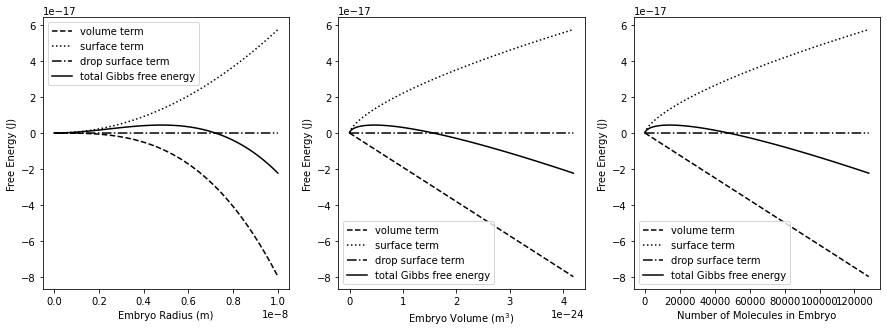

In [7]:
droprad = 5e-6
dropvol = radtovol(droprad)
water_surface_term = droplet_surface_energy(T, dropvol, radtovol(r))
deltaG = surface_term + volume_term + water_surface_term

fig, ax = plt.subplots(1,3,figsize=(15,5))

# radius
ax[0].plot(r,volume_term,label='volume term',color='black',linestyle='--')
ax[0].plot(r,surface_term,label='surface term',color='black',linestyle=':')
ax[0].plot(r,water_surface_term,label='drop surface term',color='black',linestyle='dashdot')
ax[0].plot(r,deltaG,label='total Gibbs free energy',color='black')
ax[0].set_xlabel('Embryo Radius (m)')

# volume
v = radtovol(r)
ax[1].plot(v,volume_term,label='volume term',color='black',linestyle='--')
ax[1].plot(v,surface_term,label='surface term',color='black',linestyle=':')
ax[1].plot(v,water_surface_term,label='drop surface term',color='black',linestyle='dashdot')
ax[1].plot(v,deltaG,label='total Gibbs free energy',color='black')
ax[1].set_xlabel('Embryo Volume (m$^3$)')

# molecules
N = v / v_mole_i
ax[2].plot(N,volume_term,label='volume term',color='black',linestyle='--')
ax[2].plot(N,surface_term,label='surface term',color='black',linestyle=':')
ax[2].plot(N,water_surface_term,label='drop surface term',color='black',linestyle='dashdot')
ax[2].plot(N,deltaG,label='total Gibbs free energy',color='black')
ax[2].set_xlabel('Number of Molecules in Embryo')

for ax in ax[:]:
    ax.legend()
    ax.set_ylabel('Free Energy (J)')

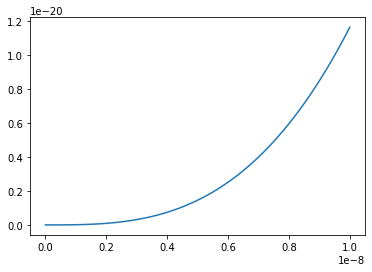

In [10]:
# How big is this new surface term?
plt.plot(r, water_surface_term);

Well nevermind... surface tension of liquid water contributes something like a thousandth of the total energy barrier, so it can safely be ignored.

